<a href="https://colab.research.google.com/github/Mastermind0309/ACP-in-Frail-Geriatric-Patients/blob/main/ACP_summary_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== Demographic / Baseline Summary ===

Continuous variables (control vs intervention):
  年齡_yr: Control=80.25, Intervention=80.19, p=0.9746 (no significant difference)
  衰弱程度: Control=4.92, Intervention=4.81, p=0.5725 (no significant difference)
  壹_二_MMSE: Control=25.47, Intervention=24.58, p=0.3590 (no significant difference)
  壹_七_HADS_total: Control=8.19, Intervention=8.83, p=0.6251 (no significant difference)
  壹_七_HADS_A: Control=2.39, Intervention=2.19, p=0.7533 (no significant difference)
  壹_七_HADS_D: Control=5.81, Intervention=6.64, p=0.4252 (no significant difference)
  K1: Control=2.97, Intervention=3.11, p=0.7053 (no significant difference)

Categorical variables (Chi-square tests):
  性別: p=0.4795 (no significant difference)
  教育程度: p=0.6159 (no significant difference)
  宗教信仰: p=0.8080 (no significant difference)
  婚姻狀態: p=0.2333 (no significant

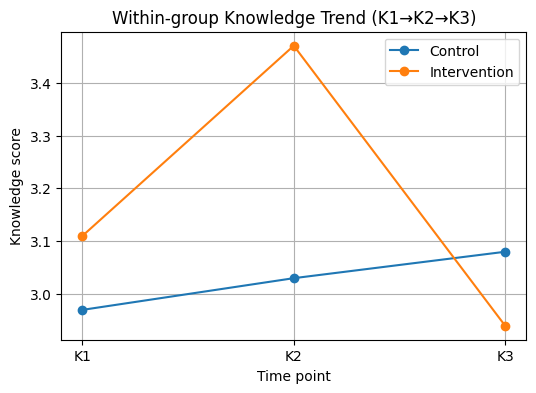


=== Plotting K1/K2/K3 between-group bar chart ===


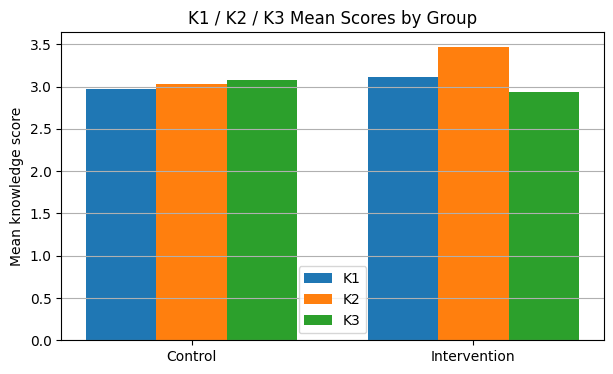


=== Plotting Logistic Regression OR for AD signing ===


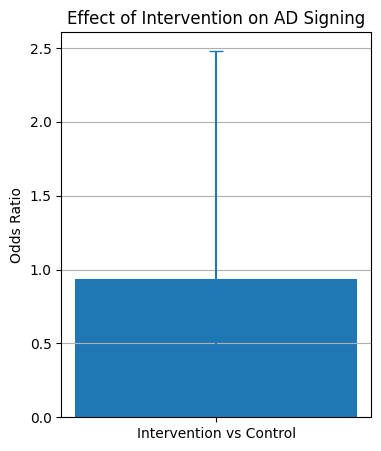

In [4]:
import re
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

# NEW: for tables & plots
import pandas as pd          # NEW
import matplotlib.pyplot as plt   # NEW

# === 1. Set your report path ===
report_path = "/content/drive/MyDrive/ACP/ACP_analysis_report_with_K123.txt"

with open(report_path, "r", encoding="utf-8") as f:
    txt = f.read()

lines = txt.splitlines()

# --------------------------------------------------
# Helper: get float from 'p=0.1234' like substrings
# --------------------------------------------------
def extract_p(s):
    m = re.search(r"p\s*=\s*([0-9.]+)", s)
    return float(m.group(1)) if m else None

# ==================================================
# A. DEMOGRAPHIC / BASELINE SUMMARY (SECTION 1)
# ==================================================
baseline_cont = []  # list of dicts: {var, mean_c, mean_i, p}
baseline_cat  = []  # list of dicts: {var, p}

i = 0
while i < len(lines):
    line = lines[i]

    # Continuous: lines like **年齡_yr**
    if line.startswith("**") and line.endswith("**"):
        var = line.strip("*")
        # Next two lines should be means and t-test
        if i+2 < len(lines):
            mean_line = lines[i+1].strip()
            p_line    = lines[i+2].strip()

            m_means = re.search(
                r"Control mean=([0-9.]+),\s*Intervention mean=([0-9.]+)",
                mean_line
            )
            p_val = extract_p(p_line)

            if m_means and p_val is not None:
                mean_c = float(m_means.group(1))
                mean_i = float(m_means.group(2))
                baseline_cont.append({
                    "var": var,
                    "mean_control": mean_c,
                    "mean_intervention": mean_i,
                    "p": p_val
                })
            i += 3
            continue

    # Categorical: blocks like
    # -- 性別 --
    # ...
    # Chi-square p=0.4795
    if line.startswith("-- ") and line.endswith(" --"):
        var = line.replace("--", "").strip()
        # search forward for the chi-square line
        j = i+1
        p_val = None
        while j < len(lines) and lines[j].strip() != "":
            if "Chi-square p=" in lines[j]:
                p_val = extract_p(lines[j])
            j += 1
        if p_val is not None:
            baseline_cat.append({
                "var": var,
                "p": p_val
            })
        i = j+1
        continue

    i += 1

# Build demographic text summary
demo_summary_lines = []
demo_summary_lines.append("=== Demographic / Baseline Summary ===")

# Continuous
demo_summary_lines.append("\nContinuous variables (control vs intervention):")
for b in baseline_cont:
    balance = "no significant difference" if b["p"] >= 0.05 else "significant difference"
    demo_summary_lines.append(
        f"  {b['var']}: "
        f"Control={b['mean_control']:.2f}, Intervention={b['mean_intervention']:.2f}, "
        f"p={b['p']:.4f} ({balance})"
    )

# Categorical
demo_summary_lines.append("\nCategorical variables (Chi-square tests):")
for b in baseline_cat:
    balance = "no significant difference" if b["p"] >= 0.05 else "significant difference"
    demo_summary_lines.append(
        f"  {b['var']}: p={b['p']:.4f} ({balance})"
    )

# ==================================================
# B. K1/K2/K3 WITHIN-GROUP (SECTION 7)
# ==================================================
# We'll scan Section 7 lines and parse Group 0 and Group 1 blocks.
section7_idx = txt.find("SECTION 7 — WITHIN-GROUP KNOWLEDGE")
section8_idx = txt.find("SECTION 8 — BETWEEN-GROUP KNOWLEDGE")

section7_text = txt[section7_idx:section8_idx] if section7_idx != -1 and section8_idx != -1 else ""

within_k = {}  # {0: {...}, 1:{...}}

for g in [0, 1]:
    pattern = rf"Group {g}.*?(?=Group [01]|\Z)"
    m = re.search(pattern, section7_text, flags=re.S)
    if not m:
        continue
    block = m.group(0)

    means = {}
    pvals = {}
    # means
    for var in ["K1", "K2", "K3"]:
        mm = re.search(rf"{var} mean\s*=\s*([0-9.]+)", block)
        if mm:
            means[var] = float(mm.group(1))
    # K1→K2, K2→K3, K1→K3
    for pair in ["K1 → K2", "K2 → K3", "K1 → K3"]:
        pm = re.search(rf"{pair}: p\s*=\s*([0-9.]+)", block)
        if pm:
            pvals[pair] = float(pm.group(1))

    within_k[g] = {"means": means, "pvals": pvals}

within_summary_lines = []
within_summary_lines.append("\n=== Within-group Knowledge Changes (K1→K2→K3) ===")

for g in [0, 1]:
    if g not in within_k:
        continue
    label = "Control (Group 0)" if g == 0 else "Intervention (Group 1)"
    wk = within_k[g]
    within_summary_lines.append(f"\n{label}:")
    if wk["means"]:
        within_summary_lines.append(
            "  Means: " +
            ", ".join([f"{k}={v:.2f}" for k, v in wk["means"].items()])
        )
    for pair, p in wk["pvals"].items():
        sig = "no significant change" if p >= 0.05 else "significant change"
        within_summary_lines.append(f"  {pair}: p={p:.4f} ({sig})")

# ==================================================
# C. K1/K2/K3 BETWEEN-GROUP (SECTION 8)
# ==================================================
section8_text = txt[section8_idx:] if section8_idx != -1 else ""

between_summary_lines = []
between_summary_lines.append("\n=== Between-group Knowledge Comparison (K1, K2, K3 & changes) ===")

# NEW: store means as well for plotting
between_k_stats = {"K1": {}, "K2": {}, "K3": {}}   # NEW

# Lines like:
# K1: control mean=2.97, intervention mean=3.11, p=0.7053
for var in ["K1", "K2", "K3"]:
    m = re.search(
        rf"{var}:\s*control mean=([0-9.]+),\s*intervention mean=([0-9.]+),\s*p=([0-9.]+)",
        section8_text
    )
    if m:
        mean_c = float(m.group(1))
        mean_i = float(m.group(2))
        p = float(m.group(3))
        sig = "no significant difference" if p >= 0.05 else "significant difference"
        between_summary_lines.append(
            f"  {var}: Control={mean_c:.2f}, Intervention={mean_i:.2f}, p={p:.4f} ({sig})"
        )
        # save for plotting
        between_k_stats[var] = {
            "mean_control": mean_c,
            "mean_intervention": mean_i,
            "p": p
        }

# Change scores: lines like 'K2_minus_K1: p=0.2356'
for var in ["K2_minus_K1", "K3_minus_K1", "K3_minus_K2"]:
    m = re.search(rf"{var}:\s*p=([0-9.]+)", section8_text)
    if m:
        p = float(m.group(1))
        sig = "no significant difference in change" if p >= 0.05 else "significant difference in change"
        between_summary_lines.append(
            f"  {var}: p={p:.4f} ({sig})"
        )

# ==================================================
# D. LOGISTIC REGRESSION SUMMARY (SECTION 6)
# ==================================================
logit_idx = txt.find("Odds ratios:")
logit_summary_lines = []
logit_summary_lines.append("\n=== Main Outcome: AD Signing (Logistic Regression) ===")

# NEW: placeholders for OR plot
logit_OR = None         # NEW
logit_CI_low = None     # NEW
logit_CI_high = None    # NEW
logit_p = None          # NEW

if logit_idx != -1:
    # Find line starting with 'group01  0.937500  0.354072  2.482282'
    odds_block = txt[logit_idx:].splitlines()
    group_or_line = None
    for line in odds_block:
        if line.strip().startswith("group01"):
            group_or_line = line
            break
    if group_or_line:
        parts = group_or_line.split()
        # Expect: name OR CI_low CI_high
        if len(parts) >= 4:
            OR = float(parts[1])
            CI_low = float(parts[2])
            CI_high = float(parts[3])
            # get p-value from model summary section above
            # search for 'group01' row in the regression table
            m_p = re.search(r"group01\s+[-0-9.]+\s+[-0-9.]+\s+[-0-9.]+\s+([0-9.]+)", txt)
            p = float(m_p.group(1)) if m_p else np.nan
            sig = "no significant effect" if p >= 0.05 else "significant effect"
            logit_summary_lines.append(
                f"  Intervention vs control: OR={OR:.3f} (95% CI {CI_low:.3f}–{CI_high:.3f}), "
                f"p={p:.4f} ({sig})"
            )
            # store for plotting
            logit_OR = OR          # NEW
            logit_CI_low = CI_low  # NEW
            logit_CI_high = CI_high# NEW
            logit_p = p            # NEW
    else:
        logit_summary_lines.append("  Could not parse group01 OR from report text.")
else:
    logit_summary_lines.append("  Could not find 'Odds ratios' section in report text.")

# ==================================================
# E. PRINT FINAL TEXT SUMMARY
# ==================================================
summary_text = "\n".join(
    demo_summary_lines +
    within_summary_lines +
    between_summary_lines +
    logit_summary_lines
)

print(summary_text)

# Optional: save to a new text file
out_path = "/content/drive/MyDrive/ACP/ACP_summary_from_report.txt"
with open(out_path, "w", encoding="utf-8") as f:
    f.write(summary_text)

print("\nSummary saved to:", out_path)

# ==================================================
# F. DRAW TABLES & FIGURES
# ==================================================

# ---------- 1. Demographic tables ----------
print("\n\n=== Demographic tables from parsed report ===")

# Continuous table
cont_df = pd.DataFrame(baseline_cont)
if not cont_df.empty:
    cont_df = cont_df[["var", "mean_control", "mean_intervention", "p"]]
    cont_df = cont_df.rename(columns={
        "var": "Variable",
        "mean_control": "Control_mean",
        "mean_intervention": "Intervention_mean",
        "p": "p_value"
    })
    print("\nContinuous baseline variables:")
    print(cont_df.to_string(index=False))
else:
    print("\nNo continuous baseline variables parsed.")

# Categorical table
cat_df = pd.DataFrame(baseline_cat)
if not cat_df.empty:
    cat_df = cat_df.rename(columns={"var": "Variable", "p": "p_value"})
    print("\nCategorical baseline variables:")
    print(cat_df.to_string(index=False))
else:
    print("\nNo categorical baseline variables parsed.")

# ---------- 2. Line chart: K1–K3 within each group ----------
print("\n\n=== Plotting K1–K3 within-group line chart ===")

plt.figure(figsize=(6,4))
x_points = [1, 2, 3]
labels_points = ["K1", "K2", "K3"]

for g in [0, 1]:
    if g not in within_k:
        continue
    means_dict = within_k[g]["means"]
    if not means_dict:
        continue
    y = [means_dict.get("K1", np.nan),
         means_dict.get("K2", np.nan),
         means_dict.get("K3", np.nan)]
    group_label = "Control" if g == 0 else "Intervention"
    plt.plot(x_points, y, marker="o", label=group_label)

plt.xticks(x_points, labels_points)
plt.xlabel("Time point")
plt.ylabel("Knowledge score")
plt.title("Within-group Knowledge Trend (K1→K2→K3)")
plt.legend()
plt.grid(True)
plt.show()

# ---------- 3. Bar chart: K1/K2/K3 between groups ----------
print("\n=== Plotting K1/K2/K3 between-group bar chart ===")

# build arrays from between_k_stats
groups = ["Control", "Intervention"]
x = np.arange(len(groups))
width = 0.25

K1_c = between_k_stats.get("K1", {}).get("mean_control", np.nan)
K1_i = between_k_stats.get("K1", {}).get("mean_intervention", np.nan)
K2_c = between_k_stats.get("K2", {}).get("mean_control", np.nan)
K2_i = between_k_stats.get("K2", {}).get("mean_intervention", np.nan)
K3_c = between_k_stats.get("K3", {}).get("mean_control", np.nan)
K3_i = between_k_stats.get("K3", {}).get("mean_intervention", np.nan)

plt.figure(figsize=(7,4))
plt.bar(x - width, [K1_c, K1_i], width, label="K1")
plt.bar(x,         [K2_c, K2_i], width, label="K2")
plt.bar(x + width, [K3_c, K3_i], width, label="K3")

plt.xticks(x, groups)
plt.ylabel("Mean knowledge score")
plt.title("K1 / K2 / K3 Mean Scores by Group")
plt.legend()
plt.grid(axis="y")
plt.show()

# ---------- 4. Bar with error bar: Logistic OR ----------
print("\n=== Plotting Logistic Regression OR for AD signing ===")

if logit_OR is not None and logit_CI_low is not None and logit_CI_high is not None:
    plt.figure(figsize=(4,5))
    plt.bar([0], [logit_OR])
    # asymmetric error bars based on CI
    lower_err = logit_OR - logit_CI_low
    upper_err = logit_CI_high - logit_OR
    plt.errorbar([0], [logit_OR], yerr=[[lower_err], [upper_err]], fmt='none', capsize=5)
    plt.xticks([0], ["Intervention vs Control"])
    plt.ylabel("Odds Ratio")
    plt.title("Effect of Intervention on AD Signing")
    plt.grid(axis="y")
    plt.show()
else:
    print("Logistic OR information not available for plotting.")




=== Demographic tables from parsed report ===

Continuous baseline variables:
      Variable  Control_mean  Intervention_mean  p_value
         年齡_yr         80.25              80.19   0.9746
          衰弱程度          4.92               4.81   0.5725
      壹_二_MMSE         25.47              24.58   0.3590
壹_七_HADS_total          8.19               8.83   0.6251
    壹_七_HADS_A          2.39               2.19   0.7533
    壹_七_HADS_D          5.81               6.64   0.4252
            K1          2.97               3.11   0.7053

Categorical baseline variables:
    Variable  p_value
          性別   0.4795
        教育程度   0.6159
        宗教信仰   0.8080
        婚姻狀態   0.2333
        收案地點   1.0000
壹_三_民眾自述健康狀態   0.7593
  壹_四_治療選擇偏好   0.5548
 壹_五_1.心肺復甦術   0.1901
 壹_五_2.氣管內插管   0.3538


=== Drawing bar charts for baseline continuous variables ===


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 40801 (\N{CJK UNIFIED IDEOGRAPH-9F61}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


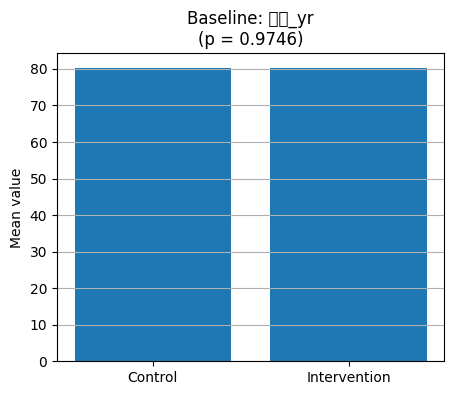

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 34928 (\N{CJK UNIFIED IDEOGRAPH-8870}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24369 (\N{CJK UNIFIED IDEOGRAPH-5F31}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31243 (\N{CJK UNIFIED IDEOGRAPH-7A0B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


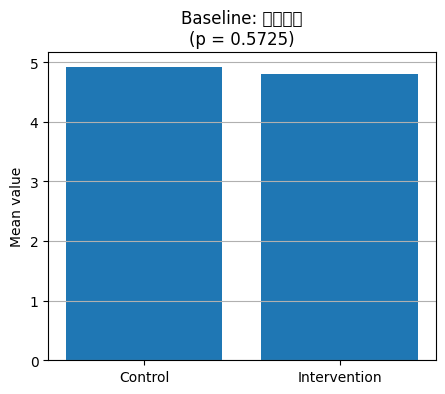

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22777 (\N{CJK UNIFIED IDEOGRAPH-58F9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20108 (\N{CJK UNIFIED IDEOGRAPH-4E8C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


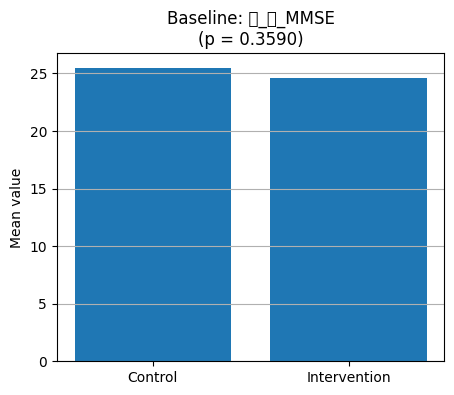

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19971 (\N{CJK UNIFIED IDEOGRAPH-4E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


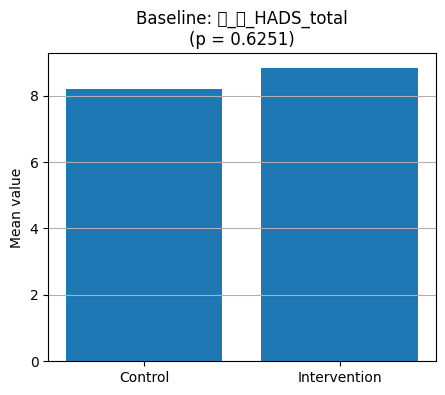

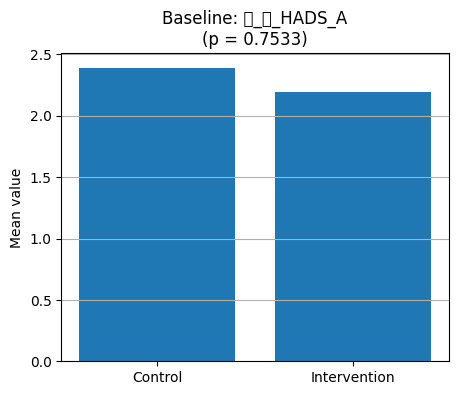

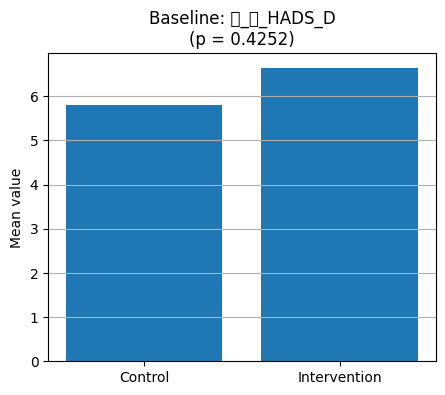

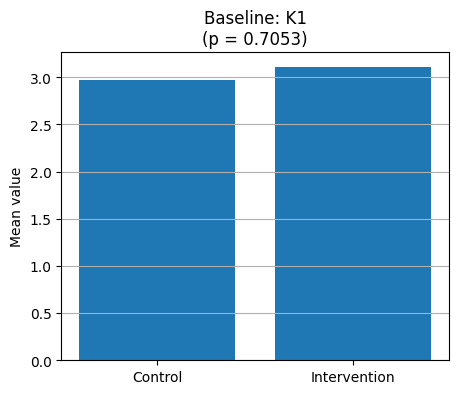

In [5]:
# ---------- 1. Demographic tables from parsed report (already in your code) ----------
print("\n\n=== Demographic tables from parsed report ===")

# Continuous table
cont_df = pd.DataFrame(baseline_cont)
if not cont_df.empty:
    cont_df = cont_df[["var", "mean_control", "mean_intervention", "p"]]
    cont_df = cont_df.rename(columns={
        "var": "Variable",
        "mean_control": "Control_mean",
        "mean_intervention": "Intervention_mean",
        "p": "p_value"
    })
    print("\nContinuous baseline variables:")
    print(cont_df.to_string(index=False))
else:
    print("\nNo continuous baseline variables parsed.")

# Categorical table
cat_df = pd.DataFrame(baseline_cat)
if not cat_df.empty:
    cat_df = cat_df.rename(columns={"var": "Variable", "p": "p_value"})
    print("\nCategorical baseline variables:")
    print(cat_df.to_string(index=False))
else:
    print("\nNo categorical baseline variables parsed.")

# ==================================================
# ✅ NEW: BAR CHARTS FOR DEMOGRAPHIC (BASELINE) VARIABLES
# ==================================================

print("\n\n=== Drawing bar charts for baseline continuous variables ===")

for b in baseline_cont:
    var = b["var"]
    mean_c = b["mean_control"]
    mean_i = b["mean_intervention"]
    p_val = b["p"]

    plt.figure(figsize=(5,4))
    plt.bar(["Control", "Intervention"], [mean_c, mean_i])
    plt.ylabel("Mean value")
    plt.title(f"Baseline: {var}\n(p = {p_val:.4f})")
    plt.grid(axis="y")
    plt.show()




=== Demographic tables from parsed report ===

Continuous baseline variables:
      Variable  Control_mean  Intervention_mean  p_value
         年齡_yr         80.25              80.19   0.9746
          衰弱程度          4.92               4.81   0.5725
      壹_二_MMSE         25.47              24.58   0.3590
壹_七_HADS_total          8.19               8.83   0.6251
    壹_七_HADS_A          2.39               2.19   0.7533
    壹_七_HADS_D          5.81               6.64   0.4252
            K1          2.97               3.11   0.7053

Categorical baseline variables:
    Variable  p_value
          性別   0.4795
        教育程度   0.6159
        宗教信仰   0.8080
        婚姻狀態   0.2333
        收案地點   1.0000
壹_三_民眾自述健康狀態   0.7593
  壹_四_治療選擇偏好   0.5548
 壹_五_1.心肺復甦術   0.1901
 壹_五_2.氣管內插管   0.3538


=== Drawing bar charts for baseline continuous variables ===


/tmp/ipython-input-4110648875.py:59: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4110648875.py:59: UserWarning: Glyph 40801 (\N{CJK UNIFIED IDEOGRAPH-9F61}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 40801 (\N{CJK UNIFIED IDEOGRAPH-9F61}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


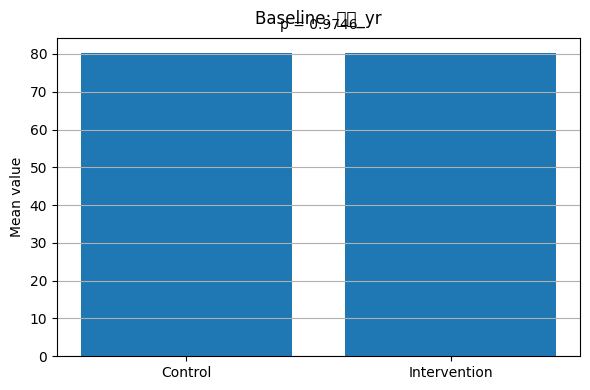

/tmp/ipython-input-4110648875.py:59: UserWarning: Glyph 34928 (\N{CJK UNIFIED IDEOGRAPH-8870}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4110648875.py:59: UserWarning: Glyph 24369 (\N{CJK UNIFIED IDEOGRAPH-5F31}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4110648875.py:59: UserWarning: Glyph 31243 (\N{CJK UNIFIED IDEOGRAPH-7A0B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4110648875.py:59: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 34928 (\N{CJK UNIFIED IDEOGRAPH-8870}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24369 (\N{CJK UNIFIED IDEOGRAPH-5F31}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(byte

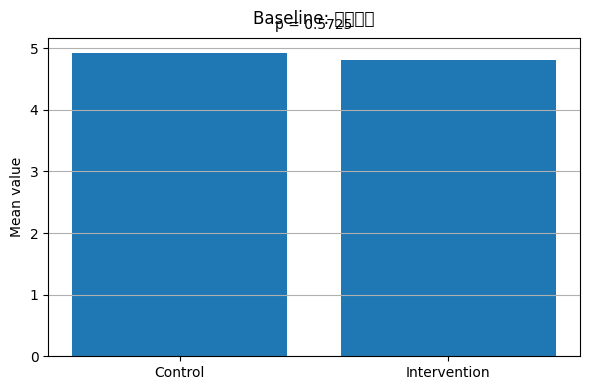

/tmp/ipython-input-4110648875.py:59: UserWarning: Glyph 22777 (\N{CJK UNIFIED IDEOGRAPH-58F9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4110648875.py:59: UserWarning: Glyph 20108 (\N{CJK UNIFIED IDEOGRAPH-4E8C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22777 (\N{CJK UNIFIED IDEOGRAPH-58F9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20108 (\N{CJK UNIFIED IDEOGRAPH-4E8C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


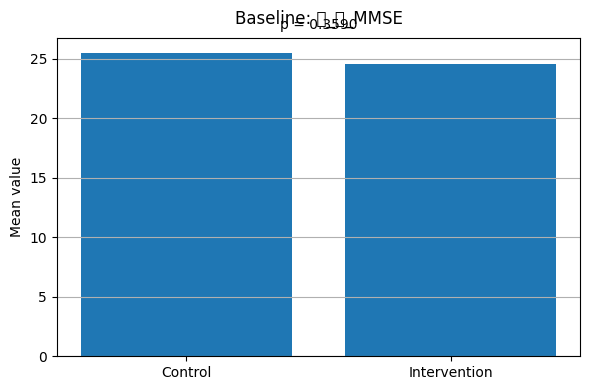

/tmp/ipython-input-4110648875.py:59: UserWarning: Glyph 19971 (\N{CJK UNIFIED IDEOGRAPH-4E03}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19971 (\N{CJK UNIFIED IDEOGRAPH-4E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


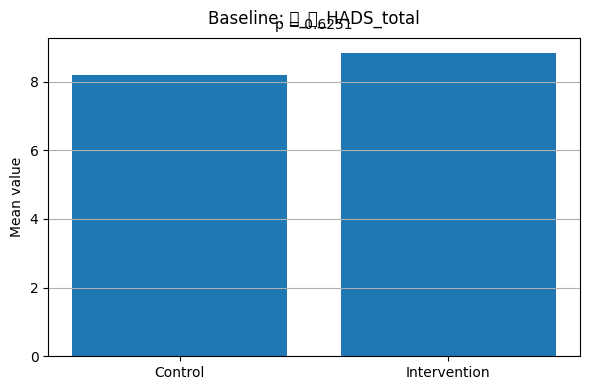

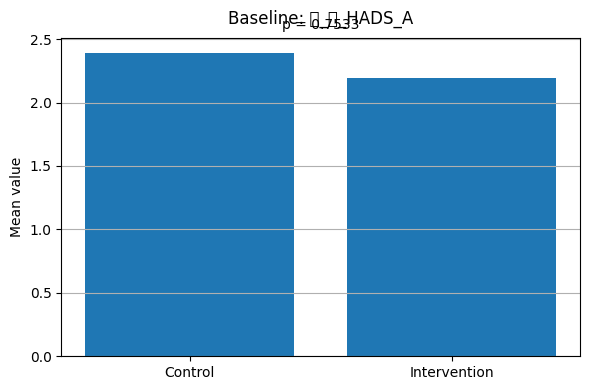

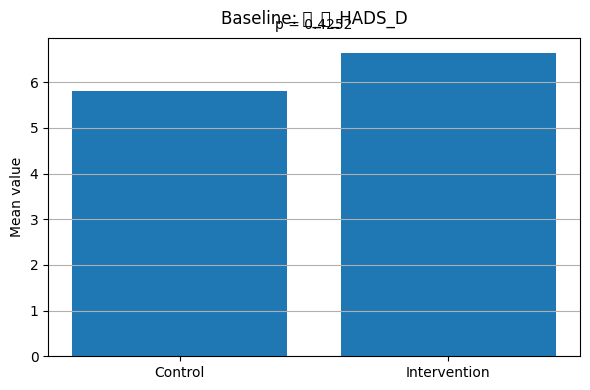

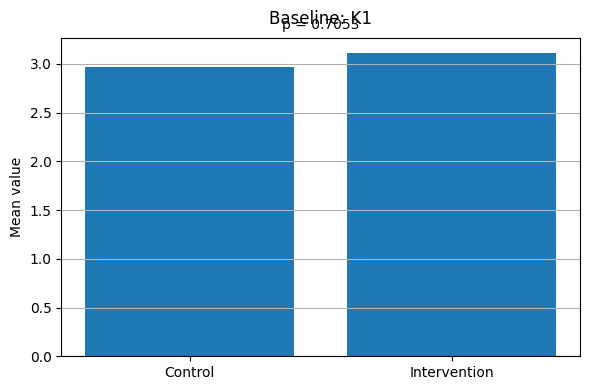

In [8]:
# ---------- 1. Demographic tables from parsed report (already in your code) ----------
print("\n\n=== Demographic tables from parsed report ===")

# Continuous table
cont_df = pd.DataFrame(baseline_cont)
if not cont_df.empty:
    cont_df = cont_df[["var", "mean_control", "mean_intervention", "p"]]
    cont_df = cont_df.rename(columns={
        "var": "Variable",
        "mean_control": "Control_mean",
        "mean_intervention": "Intervention_mean",
        "p": "p_value"
    })
    print("\nContinuous baseline variables:")
    print(cont_df.to_string(index=False))
else:
    print("\nNo continuous baseline variables parsed.")

# Categorical table
cat_df = pd.DataFrame(baseline_cat)
if not cat_df.empty:
    cat_df = cat_df.rename(columns={"var": "Variable", "p": "p_value"})
    print("\nCategorical baseline variables:")
    print(cat_df.to_string(index=False))
else:
    print("\nNo categorical baseline variables parsed.")

# ==================================================
#  BAR CHARTS FOR DEMOGRAPHIC (BASELINE) VARIABLES
# ==================================================

print("\n\n=== Drawing bar charts for baseline continuous variables ===")

for b in baseline_cont:
    var = b["var"]
    mean_c = b["mean_control"]
    mean_i = b["mean_intervention"]
    p_val = b["p"]

    plt.figure(figsize=(6,4))  # a bit wider

    plt.bar(["Control", "Intervention"], [mean_c, mean_i])
    plt.ylabel("Mean value")

    # Title: only variable name
    plt.title(f"Baseline: {var}", pad=10)

    # p-value as smaller text inside the axes (not in the title box)
    ax = plt.gca()
    ax.text(
        0.5, 1.02,            # x, y in axes coordinates
        f"p = {p_val:.4f}",
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=10
    )

    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-3296773156.py:59: UserWarning: Glyph 39000 (\N{CJK UNIFIED IDEOGRAPH-9858}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3296773156.py:59: UserWarning: Glyph 24847 (\N{CJK UNIFIED IDEOGRAPH-610F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3296773156.py:59: UserWarning: Glyph 24515 (\N{CJK UNIFIED IDEOGRAPH-5FC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3296773156.py:59: UserWarning: Glyph 32954 (\N{CJK UNIFIED IDEOGRAPH-80BA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3296773156.py:59: UserWarning: Glyph 24489 (\N{CJK UNIFIED IDEOGRAPH-5FA9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3296773156.py:59: UserWarning: Glyph 29990 (\N{CJK UNIFIED IDEOGRAPH-7526}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3296773156.py:59: UserWarning: Glyph 34899 (\N{CJK UNIFIED IDEOGRAPH-8853}) missi

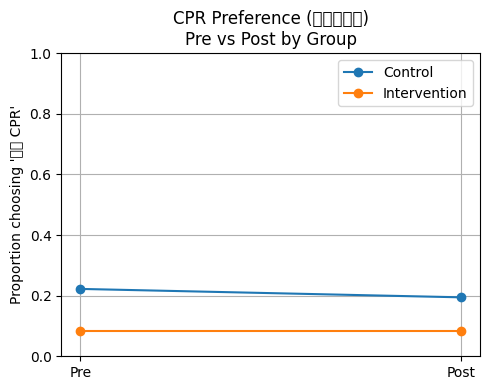

/tmp/ipython-input-3296773156.py:59: UserWarning: Glyph 25509 (\N{CJK UNIFIED IDEOGRAPH-63A5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3296773156.py:59: UserWarning: Glyph 21463 (\N{CJK UNIFIED IDEOGRAPH-53D7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3296773156.py:59: UserWarning: Glyph 25554 (\N{CJK UNIFIED IDEOGRAPH-63D2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3296773156.py:59: UserWarning: Glyph 31649 (\N{CJK UNIFIED IDEOGRAPH-7BA1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3296773156.py:59: UserWarning: Glyph 27683 (\N{CJK UNIFIED IDEOGRAPH-6C23}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3296773156.py:59: UserWarning: Glyph 20839 (\N{CJK UNIFIED IDEOGRAPH-5167}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25509 (\N

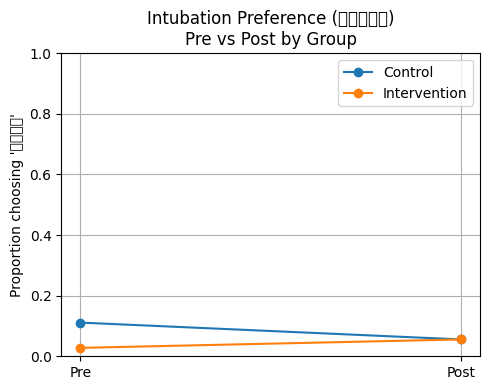

/tmp/ipython-input-3296773156.py:94: UserWarning: Glyph 21443 (\N{CJK UNIFIED IDEOGRAPH-53C3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3296773156.py:94: UserWarning: Glyph 20845 (\N{CJK UNIFIED IDEOGRAPH-516D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3296773156.py:94: UserWarning: Glyph 31805 (\N{CJK UNIFIED IDEOGRAPH-7C3D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3296773156.py:94: UserWarning: Glyph 32626 (\N{CJK UNIFIED IDEOGRAPH-7F72}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3296773156.py:94: UserWarning: Glyph 24847 (\N{CJK UNIFIED IDEOGRAPH-610F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3296773156.py:94: UserWarning: Glyph 39000 (\N{CJK UNIFIED IDEOGRAPH-9858}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21443 (\N

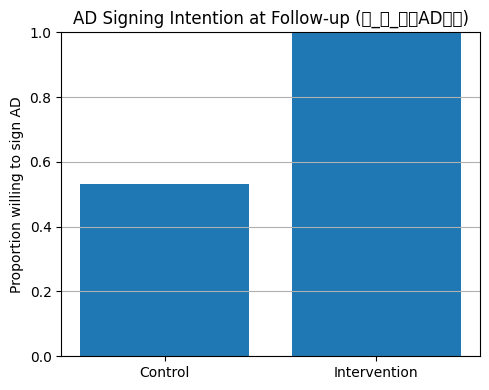

In [10]:
# ============================================================
#   FULL PRE/POST + BETWEEN-GROUP BINARY PLOT CODE
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# -----------------------------
# 1. Load Data
# -----------------------------
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/ACP/ACP_csv1202.csv"

# Big5 encoding needed for Chinese
df = pd.read_csv(file_path, encoding="big5")
df.columns = df.columns.str.strip()

# -----------------------------
# 2. Clean / recode variables
# -----------------------------
# Convert group variable
df["group01"] = df["組別"].map({"對照組":0, "實驗組":1})

# Recode AD signing (1=yes, 2=no, 999 ignored)
df["ADintent01"] = df["參_六_簽署AD意願"].replace({1:1, 2:0})
df["ADintent01"] = pd.to_numeric(df["ADintent01"], errors="coerce")


# -----------------------------
# 3. Plot function
# -----------------------------
def plot_pre_post_binary(df, pre_col, post_col, title, option1_label="Value=1"):
    """
    Generate a line chart showing pre→post change in the proportion of value==1
    for both control and intervention groups.
    """
    x = [0, 1]  # 0 = pre, 1 = post

    plt.figure(figsize=(5,4))

    for g, g_label in [(0, "Control"), (1, "Intervention")]:
        dfg = df[df["group01"] == g]

        prop_pre  = (dfg[pre_col]  == 1).mean()
        prop_post = (dfg[post_col] == 1).mean()
        y = [prop_pre, prop_post]

        plt.plot(x, y, marker="o", label=g_label)

    plt.xticks(x, ["Pre", "Post"])
    plt.ylim(0, 1)
    plt.ylabel(f"Proportion choosing '{option1_label}'")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# -----------------------------
# 4. Generate the 3 figures
# -----------------------------

# === (1) CPR ===
plot_pre_post_binary(
    df,
    pre_col="壹_五_1.心肺復甦術",
    post_col="參_二_1.心肺復甦術",
    title="CPR Preference (心肺復甦術)\nPre vs Post by Group",
    option1_label="願意 CPR"
)

# === (2) Intubation ===
plot_pre_post_binary(
    df,
    pre_col="壹_五_2.氣管內插管",
    post_col="參_二_2.氣管內插管",
    title="Intubation Preference (氣管內插管)\nPre vs Post by Group",
    option1_label="接受插管"
)

# === (3) AD Signing Intention (Between groups) ===
ad_rates = df.groupby("group01")["ADintent01"].mean()

plt.figure(figsize=(5,4))
plt.bar(["Control", "Intervention"], ad_rates.values)
plt.ylim(0, 1)
plt.ylabel("Proportion willing to sign AD")
plt.title("AD Signing Intention at Follow-up (參_六_簽署AD意願)")
plt.grid(axis="y")
plt.tight_layout()
plt.show()
